# Introduction

This notebook will explore various shooting trends and patterns of NBA players in the 2019-20 regular season. The league has increasingly revolved around the 3-point shot in recent years and the 2020 season was no different. We attempt to dissect just how widespread the 3-pointer was in 2020, and how the rapid growth of the 3, along with other trends on offense, play the leading role in the steady evolution towards "positionless basketball".

We will specifically look at differences in shooting percentages and splits across positions, and hopefully come to the "positionless" conclusion: that the distinction of different positions in the NBA is beginning to lose relevance. Think of position names in other sports — e.g., central attacking midfielder, left tackle, right defensiveman, and more — which generally do tell us where a player stays most of the time, some of their duties + responsibilities for the team, etc. It seems that in basketball, the traditional positions (PG, SG, etc.) no longer serve to capture differences in playing style, shot selection, court positioning, etc. as perhaps they should. We create a variety of aesthetic plots to illustrate this point, along with other relevant statistical trends and anomalies from the season.

Then, in an effort to group players based on these differences, we apply the k-Means clustering algorithm and create a new position system of sorts for all of the players. Players that are assigned the same position will exhibit the similar shooting statistics and other offensive metrics. In addition, we'll use a k Nearest Neighbors clustering to be more specific in our mission to find the most similar players on offense. We will find, for any given player, a set of players with the most similar style of play according to designated stat categories. This clustering can potentially serve to point towards hypothetical replacements for players who perhaps depart from a team (a very relevant issue in this age of player movement and freedom). Alternatively, one could look at the outputted similar players as a basis for a young, up-and-coming player's adaptation/improvement of his game.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Loading the Data

In [2]:
# Import per-game statistics
per_game_stats = pd.read_csv('../Data/Raw/nba_2020_per_game.csv', index_col = 0)

In [3]:
per_game_stats.head()

,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Player,,,,,,,,,,,,,,,,,,,,,
Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,0.0,...,0.582,3.3,6.0,9.3,2.3,0.8,1.1,1.5,1.9,10.9
Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,0.557,0.0,...,0.691,2.4,7.8,10.2,5.1,1.1,1.3,2.8,2.5,15.9
LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,0.493,1.2,...,0.827,1.9,5.5,7.4,2.4,0.7,1.6,1.4,2.4,18.9
Kyle Alexander,PF,23,MIA,2,0,6.5,0.5,1.0,0.500,0.0,...,NaN,1.0,0.5,1.5,0.0,0.0,0.0,0.5,0.5,1.0
Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,1.0,...,0.676,0.2,1.6,1.8,1.9,0.4,0.2,1.1,1.2,5.7


In [4]:
# Import shooting statistics
shooting_stats = pd.read_csv('../Data/raw/nba_2020_shooting.csv', index_col = 0)

In [5]:
shooting_stats.head()

,Pos,Age,Tm,G,MP,FG%,Dist.,2P Proportion,0-3 Proportion,3-10 Proportion,...,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,# Dunks,%3PA Corner 3s,3P% Corner 3s,Att. Heaves,# Heaves
Player,,,,,,,,,,,,,,,,,,,,,
Steven Adams,C,26,OKC,63,1680,0.592,4.4,0.994,0.513,0.397,...,1.000,0.333,0.670,1.000,0.176,78,0.333,0.000,1,1
Bam Adebayo,PF,22,MIA,72,2417,0.557,5.8,0.982,0.481,0.301,...,0.227,0.143,0.715,0.500,0.219,157,0.571,0.125,1,0
LaMarcus Aldridge,C,34,SAS,53,1754,0.493,13.7,0.802,0.202,0.129,...,0.433,0.389,0.567,0.951,0.044,31,0.185,0.379,1,0
Kyle Alexander,PF,23,MIA,2,13,0.500,1.5,1.000,1.000,0.000,...,NaN,NaN,0.000,NaN,0.000,0,NaN,NaN,0,0
Nickeil Alexander-Walker,SG,21,NOP,47,591,0.368,15.9,0.500,0.244,0.173,...,0.375,0.346,0.192,0.913,0.008,2,0.188,0.360,4,0


# Cleaning the Data

## Merging the 2 Data Frames into 1

In [6]:
stats = pd.concat([per_game_stats, shooting_stats.iloc[:, 6:]], axis = 1)

In [7]:
stats.head()

,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,...,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,# Dunks,%3PA Corner 3s,3P% Corner 3s,Att. Heaves,# Heaves
Player,,,,,,,,,,,,,,,,,,,,,
Steven Adams,C,26,OKC,63,63,26.7,4.5,7.6,0.592,0.0,...,1.000,0.333,0.670,1.000,0.176,78,0.333,0.000,1,1
Bam Adebayo,PF,22,MIA,72,72,33.6,6.1,11.0,0.557,0.0,...,0.227,0.143,0.715,0.500,0.219,157,0.571,0.125,1,0
LaMarcus Aldridge,C,34,SAS,53,53,33.1,7.4,15.0,0.493,1.2,...,0.433,0.389,0.567,0.951,0.044,31,0.185,0.379,1,0
Kyle Alexander,PF,23,MIA,2,0,6.5,0.5,1.0,0.500,0.0,...,NaN,NaN,0.000,NaN,0.000,0,NaN,NaN,0,0
Nickeil Alexander-Walker,SG,21,NOP,47,1,12.6,2.1,5.7,0.368,1.0,...,0.375,0.346,0.192,0.913,0.008,2,0.188,0.360,4,0


In [8]:
print("The dataset contains {} players with {} different statistical categories.".format(stats.shape[0], stats.shape[1]))

The dataset contains 651 players with 49 different statistical categories.


## Missing Values

In [12]:
stats.isnull().sum()

Pos                    0
Age                    0
Tm                     0
G                      0
GS                     0
MP                     0
FG                     0
FGA                    0
FG%                    2
3P                     0
3PA                    0
3P%                   35
2P                     0
2PA                    0
2P%                    6
eFG%                   2
FT                     0
FTA                    0
FT%                   33
ORB                    0
DRB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
PTS                    0
Dist.                  2
2P Proportion          2
0-3 Proportion         2
3-10 Proportion        2
10-16 Proportion       2
16-3P Proportion       2
3P Proportion          2
2P FG%                 6
0-3 FG%               24
3-10 FG%              36
10-16 FG%             79
16-3P FG%             99


In our case, it probably makes the most sense to simply impute all of the missing values with 0, since it is likely that the reason that a particular statistic is missing for a player is that the player simply didn't register enough/any attempts in that category.

In [13]:
stats.fillna(0, inplace = True)
stats.isnull().sum().sum()

0

There are now no missing values in the data, so we can move forward.

## Multiple Rows for the Same Player

In some cases, one player will have more than one row in the data; this is due to players switching teams mid-season and having one row for each of their teams. Here, we'll replace these multiple rows with a single row containing averages across all of the player's teams. (We could make this a weighted average, but since we shouldn't expect players' averages to change *too* much from one team to another, a simple mean should be fine.)

In [14]:
df = stats.groupby(level = 0).mean().round(3)

Looks like we lost our categorical Position and Team columns in the process (this has to do with how the apply function works on a groupby object). Let's get those columns back in order below.

In [15]:
cat_features = ['Pos', 'Tm']

In [16]:
df = stats.groupby(level = 0).apply(lambda x: x.iloc[0])[cat_features].merge(df, left_index = True, right_index = True)

In [17]:
df.head()

,Pos,Tm,Age,G,GS,MP,FG,FGA,FG%,3P,...,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,# Dunks,%3PA Corner 3s,3P% Corner 3s,Att. Heaves,# Heaves
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,PF,ORL,24,62.0,62.0,32.5,5.4,12.4,0.437,1.2,...,0.162,0.308,0.500,0.890,0.124,88.0,0.177,0.333,6.0,0.0
Aaron Holiday,PG,IND,23,66.0,33.0,24.5,3.5,8.5,0.414,1.3,...,0.407,0.394,0.288,0.839,0.005,2.0,0.167,0.432,1.0,0.0
Abdel Nader,SF,OKC,26,55.0,6.0,15.8,2.2,4.8,0.468,0.9,...,0.250,0.375,0.653,0.979,0.034,9.0,0.328,0.429,0.0,0.0
Adam Mokoka,SG,CHI,21,11.0,0.0,10.2,1.1,2.5,0.429,0.5,...,0.000,0.400,0.667,1.000,0.000,0.0,0.533,0.375,0.0,0.0
Admiral Schofield,SF,WAS,22,33.0,2.0,11.2,1.1,2.8,0.380,0.6,...,0.500,0.311,0.688,1.000,0.033,2.0,0.295,0.500,1.0,0.0


In [18]:
print("We now have {} players with {} different statistical categories.".format(df.shape[0], df.shape[1]))

We now have 529 players with 49 different statistical categories.


## Clean 'Pos' Column

A few of the positions are not as clean as we would like

In [19]:
df['Pos'].value_counts()

SG       139
PF       101
PG        95
C         94
SF        89
SF-PF      4
SF-SG      3
PF-C       2
C-PF       2
Name: Pos, dtype: int64

We want to classify every player as one of the 5 textbook positions: PG, SG, SF, PF, C. Let's parse out the "-PF", etc. attached to some of the position tags.

In [20]:
df['Pos'] = df['Pos'].apply(lambda x: x.split('-')[0])

In [21]:
df['Pos'].value_counts()

SG    139
PF    103
C      96
SF     96
PG     95
Name: Pos, dtype: int64

## Set Games and Minutes Played Requirement

We really only want to consider players who played a statistically significant amount this season. (These cutoffs are somewhat arbitrary, but that's okay; we just want to filter out players who had very limited playing time.)

In [22]:
games_req = 30
mins_req = 15

In [23]:
df = df.loc[df['G'] >= games_req].loc[df['MP'] >= mins_req]

In [24]:
print("We are left with {} eligible players.".format(df.shape[0]))

We are left with 295 eligible players.


## Overview of Cleaned Data

Now all of our stats are gathered in one final, cleaned data frame, and we can work directly with this single *df* from here on out. Let's quickly look over this *df*:

In [25]:
df.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,# Dunks,%3PA Corner 3s,3P% Corner 3s,Att. Heaves,# Heaves
count,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,...,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000,295.000000
mean,26.023729,56.774007,33.112986,25.597973,4.422824,9.559878,0.464468,1.314234,3.631973,0.332044,...,0.352905,0.332044,0.536512,0.817383,0.070414,28.711871,0.232108,0.362115,1.149163,0.030508
std,4.066134,11.379868,24.373312,6.030496,2.092351,4.406871,0.069659,0.894867,2.287051,0.092464,...,0.171346,0.092464,0.192773,0.237256,0.097320,36.583071,0.149039,0.149258,1.615185,0.172274
min,19.000000,30.000000,0.000000,15.100000,1.300000,3.000000,0.333000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.099000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,48.500000,8.500000,19.900000,2.850000,6.000000,0.423000,0.700000,2.166500,0.314000,...,0.277000,0.314000,0.391000,0.753500,0.011000,4.000000,0.137000,0.313000,0.000000,0.000000
50%,26.000000,59.000000,32.000000,25.800000,3.900000,8.300000,0.449000,1.200000,3.400000,0.352000,...,0.383000,0.352000,0.564000,0.902000,0.037000,16.000000,0.210000,0.382000,1.000000,0.000000
75%,29.000000,66.000000,57.000000,30.750000,5.700000,12.333500,0.487000,1.900000,5.000000,0.382500,...,0.454000,0.382500,0.696500,0.973000,0.086500,35.500000,0.307500,0.436000,2.000000,0.000000
max,38.000000,74.000000,73.000000,37.500000,10.900000,22.900000,0.742000,4.400000,12.400000,0.600000,...,1.000000,0.600000,0.897000,1.000000,0.616000,221.000000,1.000000,1.000000,11.000000,1.000000


In [26]:
df.columns

Index(['Pos', 'Tm', 'Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Dist.',
       '2P Proportion', '0-3 Proportion', '3-10 Proportion',
       '10-16 Proportion', '16-3P Proportion', '3P Proportion', '2P FG%',
       '0-3 FG%', '3-10 FG%', '10-16 FG%', '16-3P FG%', '3P FG%',
       '2P Proportion Astd', '3P Proportion Astd', '%FGA Dunks', '# Dunks',
       '%3PA Corner 3s', '3P% Corner 3s', 'Att. Heaves', '# Heaves'],
      dtype='object')

In [27]:
# Ouput cleaned data to new csv file
df.to_csv('../Data/Cleaned/nba_2020_shooting_stats_cleaned.csv')

# Visualizations

In [33]:
# Set style for ensuing plots
plt.style.use(['seaborn-whitegrid'])
sns.set_palette('pastel')

In [34]:
# Set default font styles + sizes
font = {'family' : 'helvetica',
        'weight' : 'normal',
        'size' : 14}
plt.rc('font', **font)  # Pass in the font dict as kwargs
plt.rc('axes', labelsize = 20)
plt.rc('axes', titlesize = 28)
plt.rc('figure', titlesize = 28)

Let's now do a quick visual overview of some of this season's shooting trends.

## How Do the Top Scorers Shoot?

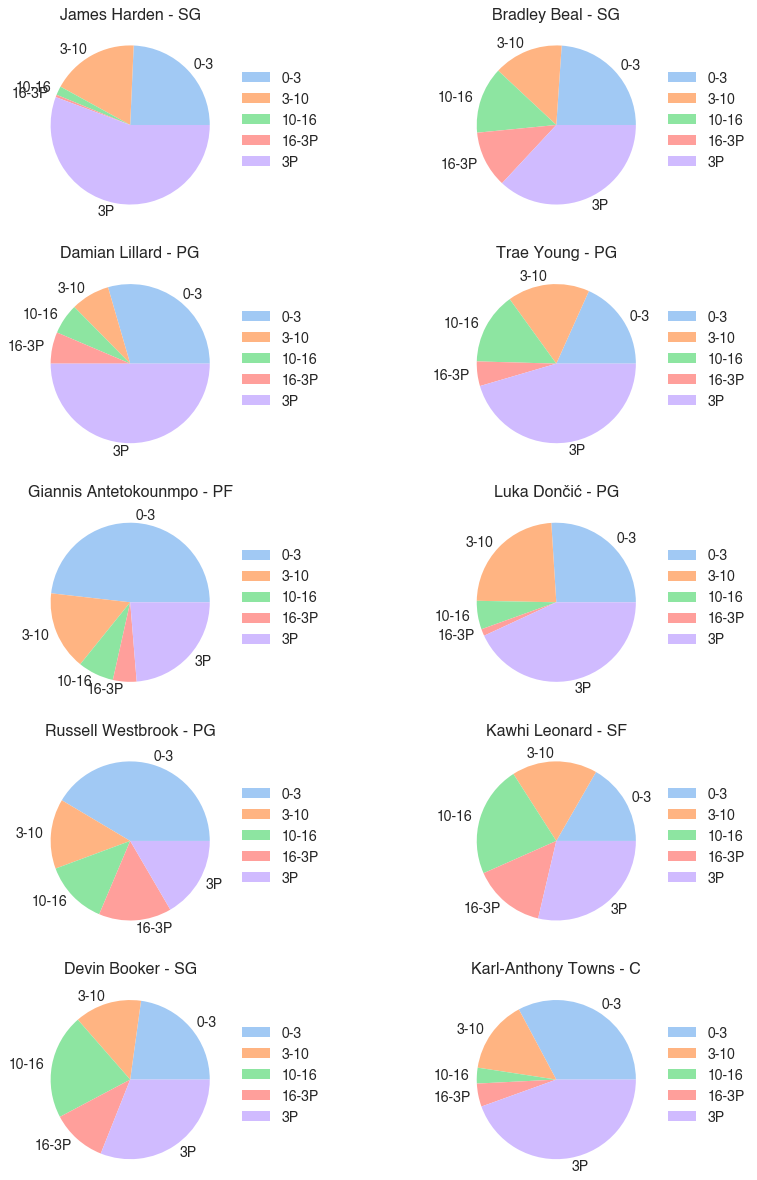

In [35]:
# How the top scorers got their buckets, broken down by shooting range
df_top_scorers = df.sort_values('PTS', ascending = False)[:20]
shooting_ranges = ['0-3 Proportion', '3-10 Proportion', '10-16 Proportion', '16-3P Proportion', '3P Proportion']
shooting_range_labels = [x.replace(' Proportion', '') for x in shooting_ranges]

fig, axes = plt.subplots(5, 2, figsize = (14, 20))

for i, ax in enumerate(axes.flatten()):
    ax.pie(x = df_top_scorers[shooting_ranges].iloc[i], labels = shooting_range_labels, radius = 1.5, normalize = True)
    ax.set_title(df_top_scorers.index[i] + ' - ' + df_top_scorers['Pos'][i], fontsize = 16, pad = 40)
    ax.legend(bbox_to_anchor=(1.25, 1), fontsize = 14)
    
fig.subplots_adjust(hspace = 0.8);

We can quickly see a couple simple things:
- The relative lack of mid-range shooting is very apparent
- The 3-point shot dominates many of the top scorer's shooting proportions

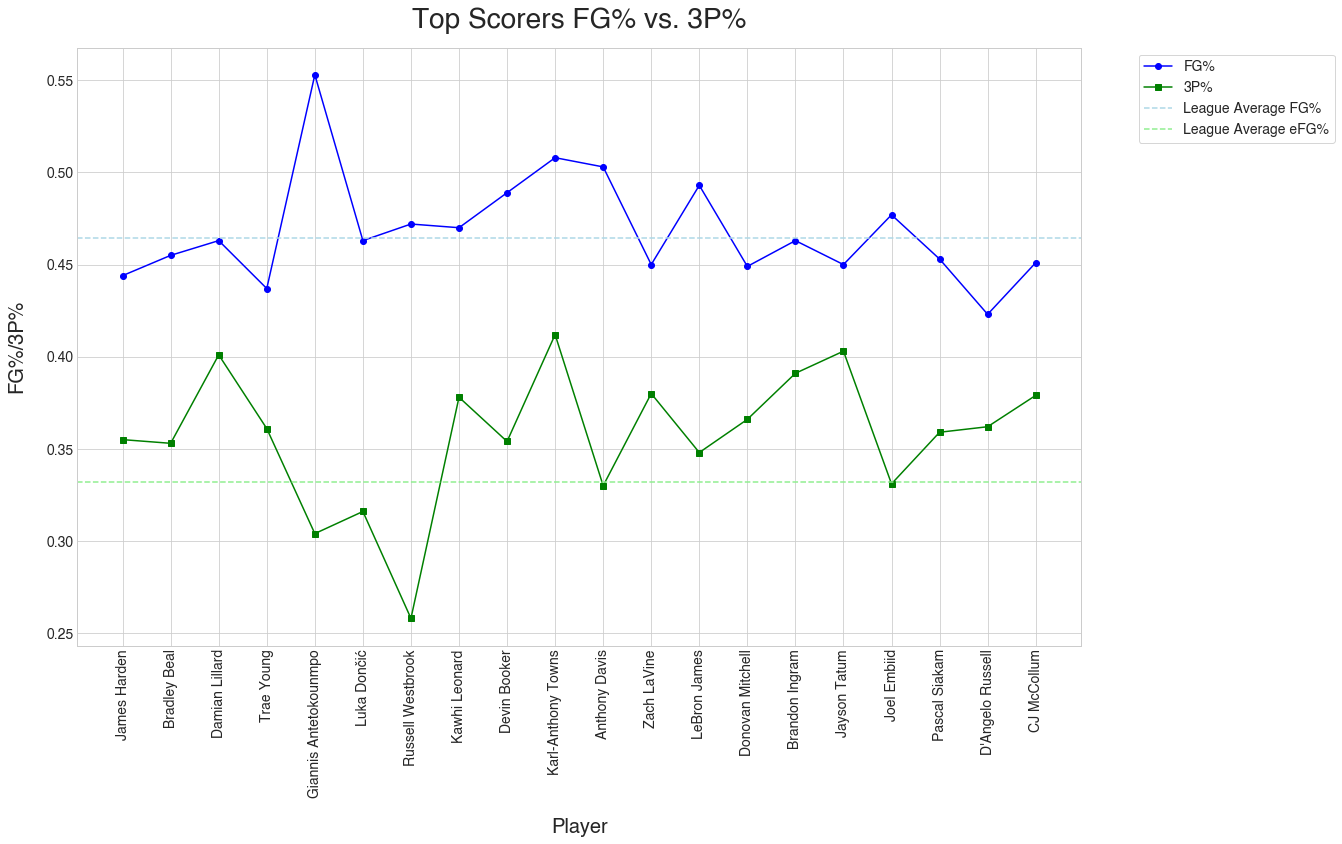

In [37]:
# How (relatively) efficient these top scorers were
fig, ax = plt.subplots(figsize = (18, 11))

ax.plot('FG%', data = df_top_scorers, marker = 'o', color = 'blue')
ax.plot('3P%', data = df_top_scorers, marker = 's', color = 'green')
ax.axhline(y = np.mean(df['FG%']), linestyle = 'dashed', color = 'lightblue', label = 'League Average FG%')
ax.axhline(y = np.mean(df['3P%']), linestyle = 'dashed', color = 'lightgreen', label = 'League Average eFG%')

ax.set_xlabel('Player', labelpad = 20)
ax.set_ylabel('FG%/3P%', labelpad = 20)
ax.set_xticks(df_top_scorers.index)
ax.set_xticklabels(df_top_scorers.index, rotation = 90)
ax.set_title("Top Scorers FG% vs. 3P%", pad = 20)
ax.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), frameon = True)

plt.axis('tight');

The above plot lets us easily spot the shooting efficiency of these top players. For example, we can see that with a couple exceptions, the top scorers are mostly above average 3-point shooters, again emphasizing the importance of the 3-point shot in the modern NBA. Interestingly enough, two of the worst 3-point shooters depicted are point guards, not big men as would be the typical culprit for poor perimeter shooting before the "positionless" evolution.

Those were the top scorers, but how about the rest of the league? Let's now take a closer look at the use (and sometimes misuse) of the 3-ball in particular, throughout the whole league.

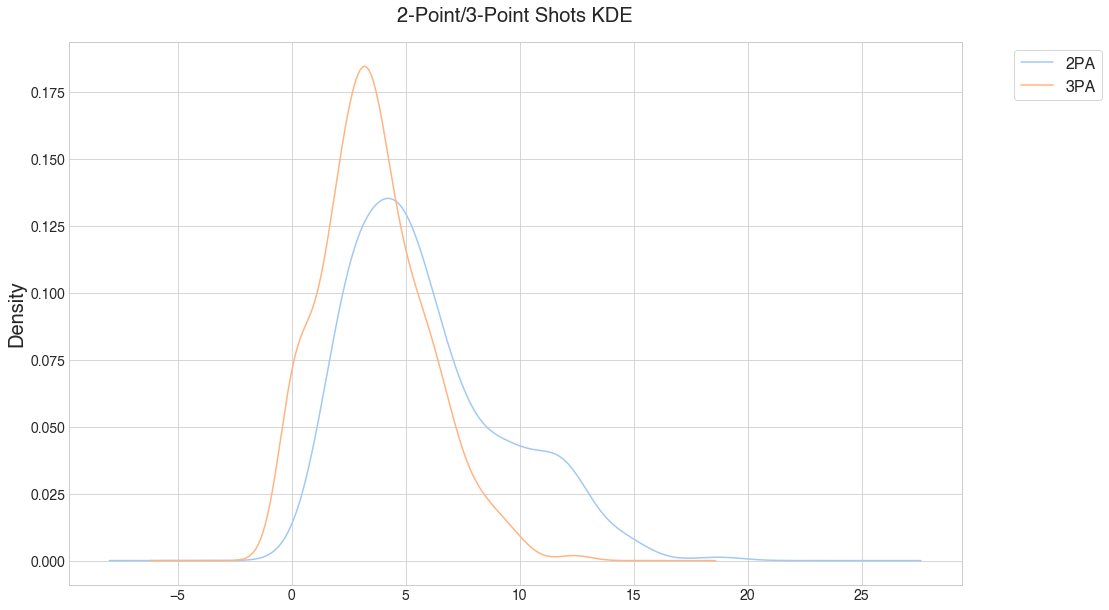

In [132]:
fig, ax = plt.subplots(figsize = (16, 10))

df[['2PA', '3PA']].plot.kde(ax = ax)

ax.set_title("2-Point/3-Point Shots KDE", fontsize = 20, pad = 20)
ax.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), frameon = True)

plt.show();

The density curves for 2PA and 3PA are pretty close to each other here! Players are almost at the point where 3-point attempts match 2-point attempts - that is, almost every other shot they take is a 3 (almost). However, when it comes to other shot types, particularly mid-range shots, a whole different trend exists.

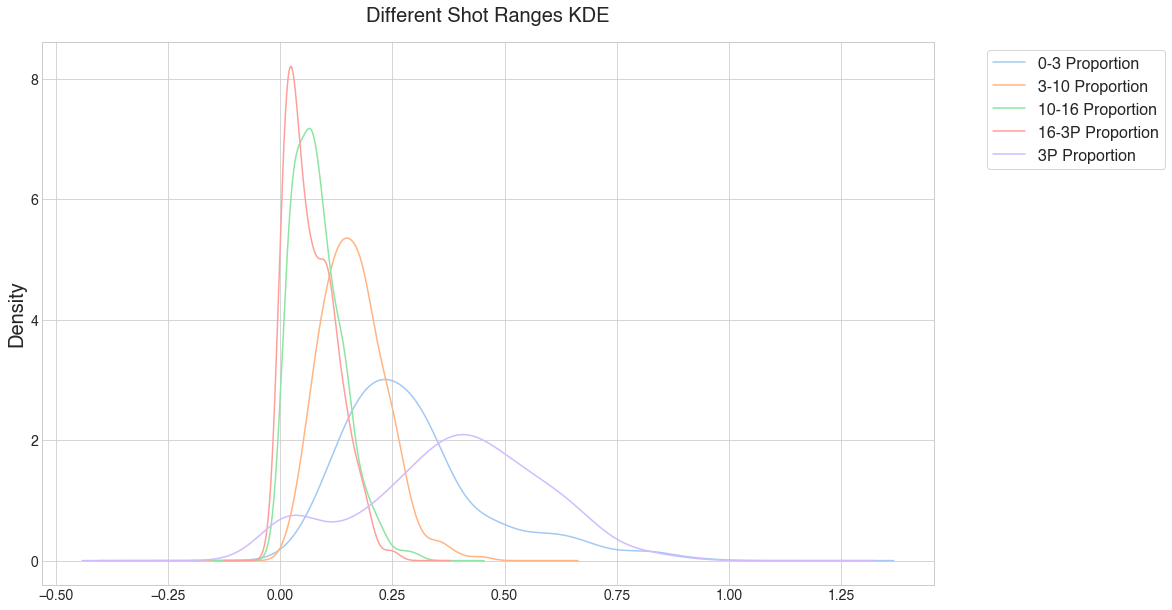

In [133]:
fig, ax = plt.subplots(figsize = (16, 10))

df[['0-3 Proportion', '3-10 Proportion', '10-16 Proportion', '16-3P Proportion', '3P Proportion']].plot.kde(ax = ax)

ax.set_title("Different Shot Ranges KDE", fontsize = 20, pad = 20)
ax.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), frameon = True)

plt.show();

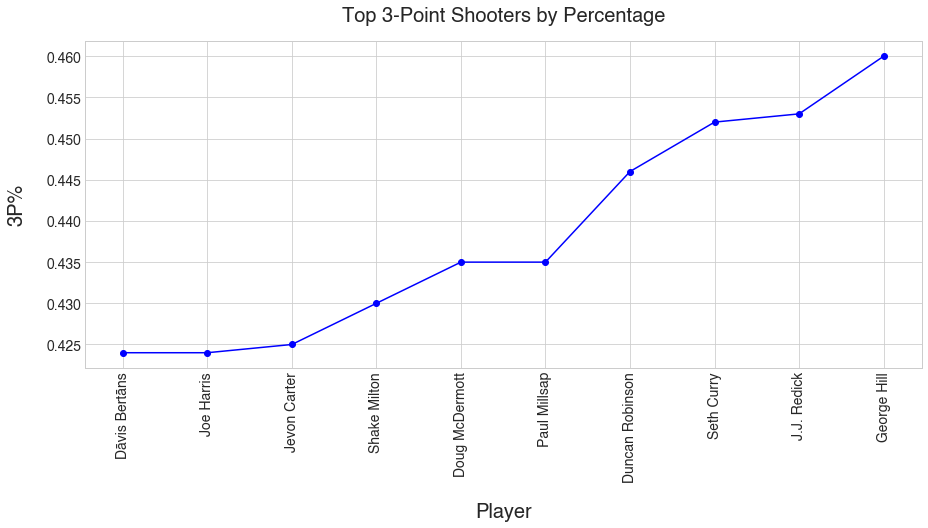

In [134]:
# The league's very best 3-point shooters
df_3P_shooters = df[df['3PA'] >= 1]    # Set an attempts requirement

fig, ax = plt.subplots(figsize = (15, 6))
ax.plot('3P FG%', data = df_3P_shooters.sort_values('3P FG%', ascending = False)[:10].iloc[::-1], marker = 'o', color = 'blue')

ax.set_xlabel('Player', labelpad = 20)
ax.set_ylabel('3P%', labelpad = 20)
ax.set_xticks(df_3P_shooters.index)
ax.set_xticklabels(df_3P_shooters.index, rotation = 90)
ax.set_title("Top 3-Point Shooters by Percentage", fontsize = 20, pad = 20)


plt.axis('tight');

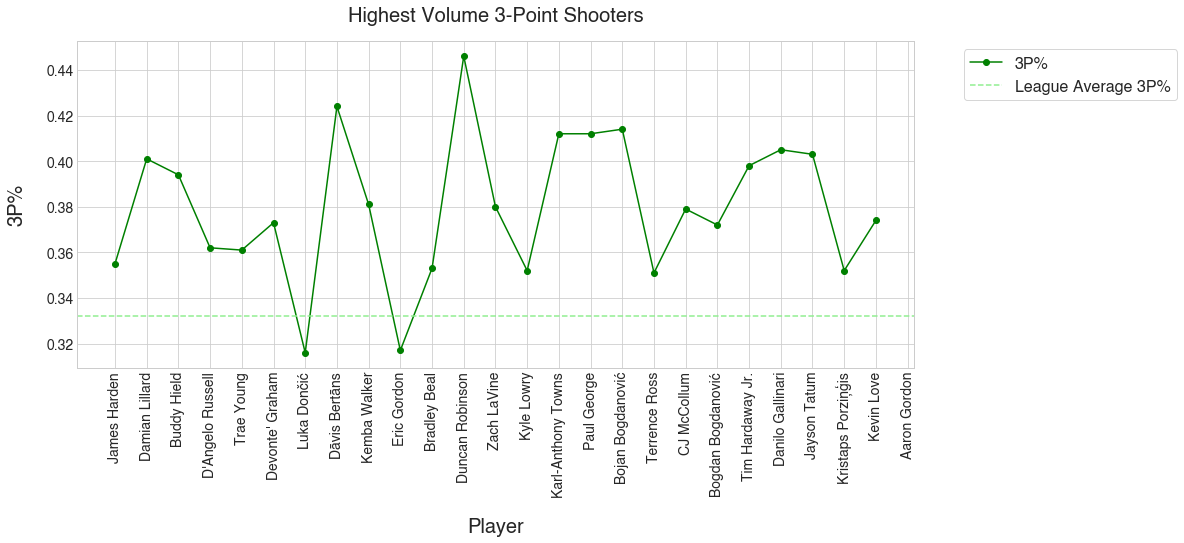

In [140]:
fig, ax = plt.subplots(figsize = (15, 6))

ax.plot('3P%', data = df_3P_shooters.sort_values('3PA', ascending = False)[:25], marker = 'o', color = 'green')
ax.axhline(y = np.mean(df['3P%']), linestyle = 'dashed', label = "League Average 3P%", color = 'lightgreen')

ax.set_xlabel('Player', labelpad = 20)
ax.set_ylabel('3P%', labelpad = 20)
ax.set_xticks(df_3P_shooters.index)
ax.set_xticklabels(df_3P_shooters.index, rotation = 90)
ax.set_title("Highest Volume 3-Point Shooters", fontsize = 20, pad = 20)
ax.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), frameon = True)

plt.axis('tight');

In [149]:
plt.figure()

fig = px.scatter(df_3P_shooters, x = '3PA', y = '3P%', hover_data = [df_3P_shooters.index], size = 'FGA', color = 'Pos')

fig.update_layout(title_text = "3-Point Shooting Across Positions", title_x = 0.5, xaxis_title = '3-Point Attempts', yaxis_title = '3-Point Field Goal %')

fig.show();

<Figure size 432x288 with 0 Axes>

Here, at a glance, we see a couple noteworthy things. We can notice our first indicator that the league truly is shifting towards being "positionless" (at least in the case of 3-pointers). While a lot of centers still don't shoot the 3 too much, it is still a blurred line in 3-point attempts and percentages across the other 4 positions - look especially at the middle of the above plot, around 2-5 3PA, where all of the positions are blended together. 

We can even notice the traditional positions' losing their differentiating power by looking at the several preceding plots. Quite a few of the league-leading 3-point shooters are not your traditional smaller guards: look at Robinson(SF), Bertans(PF), McDermott(PF), Millsap(PF), and so on. (Side note: conversely, many of the worst shooters are actually guards)

In [150]:
# An alternate view of the idea mentioned above
plt.figure()

fig = px.scatter(df, x = 'FGA', y = '3PA', hover_data = [df.index], color = 'Pos')

fig.update_layout(title_text = "Shooting Attempts Across Positions", title_x = 0.5, xaxis_title = '3-Point Attempts', yaxis_title = '3-Point Field Goal %')

fig.show();

<Figure size 432x288 with 0 Axes>

Okay, so we've established just how prevelant the 3-pointer is in the modern NBA, from the very best scorers to catching-and-shooting aficionados. Now, let's narrow down the problem at hand to our original claim: that the league is going positionless and there is a need for a more defining positional nomenclature to distinguish different classes of players.

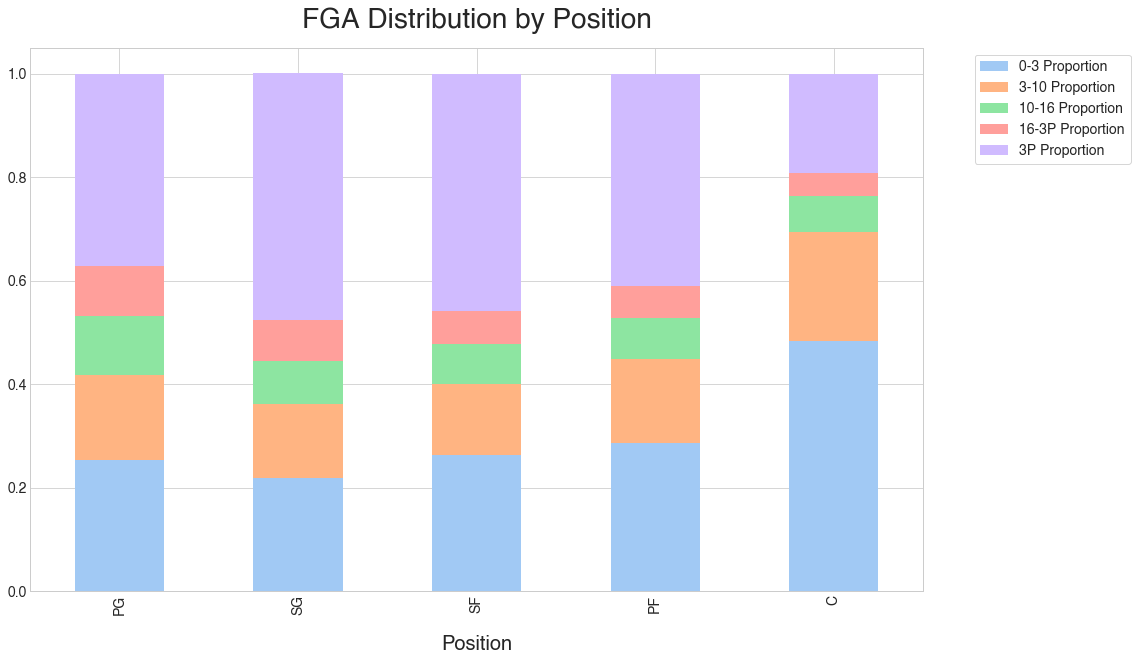

In [44]:
fig, ax = plt.subplots(figsize = (16, 10))

df_by_pos = df.groupby('Pos').apply(np.mean).reindex(['PG', 'SG', 'SF', 'PF', 'C'])

df_by_pos[['0-3 Proportion', '3-10 Proportion', '10-16 Proportion', '16-3P Proportion', '3P Proportion']].plot.bar(stacked = True, ax = ax)

ax.set_xlabel('Position', labelpad = 20)
ax.set_title("FGA Distribution by Position", pad = 20)
ax.legend(loc = 'upper left', bbox_to_anchor = (1.05, 1), frameon = True)

plt.show();

This clearly show the wide use and overall importance of the 3-point shot in today's NBA; in fact, for 4 of the 5 positions,  

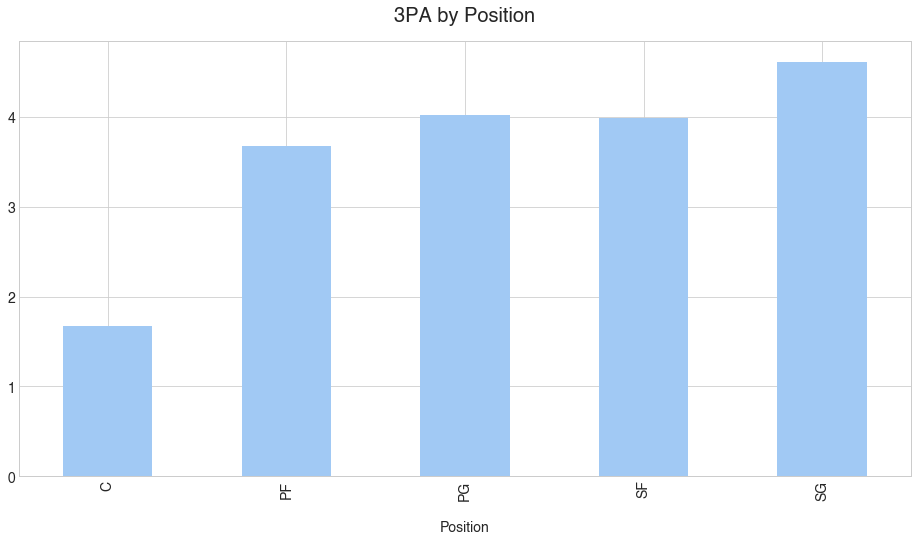

In [45]:
df_by_pos = df.groupby('Pos').apply(np.mean)

fig, ax = plt.subplots(figsize = (16, 8))

ax = df_by_pos['3PA'].plot.bar()
ax.set_xlabel('Position', fontsize = 14, labelpad = 20)
ax.set_title("3PA by Position", fontsize = 20, pad = 20)

plt.show();

It's becoming pretty difficult to discern between different positions looking at the shooting numbers. Imagine looking at this plot and trying to denote which bar corresponded to which position. Pretty difficult, apart from perhaps the Center bar. And isn't shooting arguably the most defining statistic for separating types of players? 

In the book, *Basketball on Paper* (which is basketball's version of *Moneyball* and an excellent read for sports analytics junkies), Dean Oliver identified what he called the "Four Factors of Basketball Success":

- Shooting (40%)
- Turnovers (25%)
- Rebounding (20%)
- Free Throws (15%)

Shooting is the most important factor, followed by turnovers, rebounding, and free throws. The "Four Factors" were based on Oliver's extension research of the stats behind winning teams. He claims that shooting is the most important factor. As a side note, this is part of the inspiration behind my using shooting stats as the primary basis for recategorizing players into newly defined positions.

(source: https://www.breakthroughbasketball.com/stats/effective-field-goal-percentage.html)

On the other hand, consider how these similar plots - using two other stats mentioned in Oliver's four factors - may be used to distinguish across different positions:

Text(0.5, 1.0, 'Turnovers by Position')

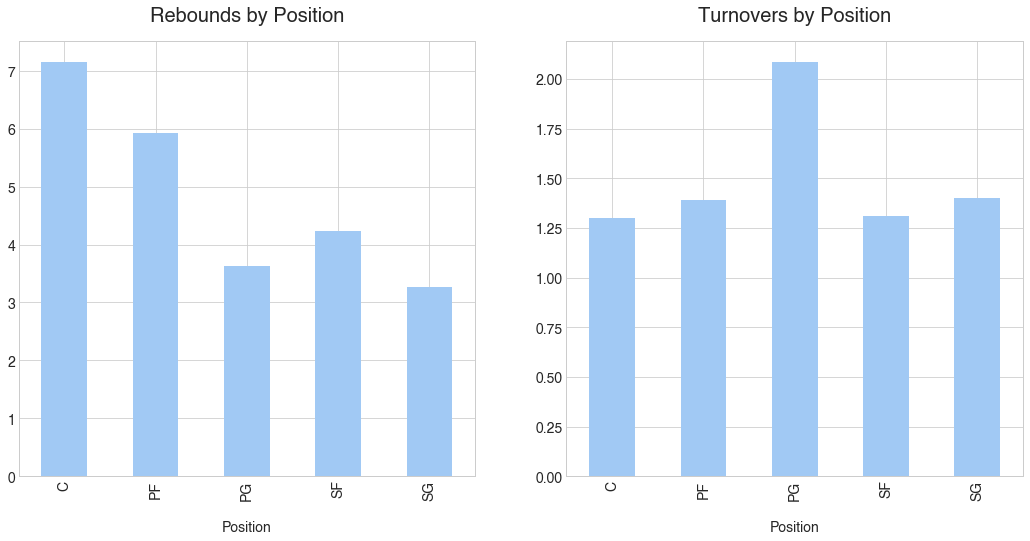

In [40]:
df_by_pos = df.groupby('Pos').apply(np.mean)

fig, axes = plt.subplots(1, 2, figsize = (18, 8))

df_by_pos['TRB'].plot.bar(ax=axes[0])
axes[0].set_xlabel('Position', fontsize = 14, labelpad = 20)
axes[0].set_title("Rebounds by Position", fontsize = 20, pad = 20)

df_by_pos['TOV'].plot.bar(ax=axes[1])
axes[1].set_xlabel('Position', fontsize = 14, labelpad = 20)
axes[1].set_title("Turnovers by Position", fontsize = 20, pad = 20)


Not perfect, but definitely more informative than the 3-point chart. Someone with moderate basketball knowledge could easily determine which bars correspond to the centers and power forwards in the rebounding chart, and the turnovers chart, if nothing else, show a clear gap between point guards and non-PGs.

In summary, with the exception of the center position, positions really become blurred together when it comes to shot selection. The 3 has become so ingrained into the modern game that the traditional positions don't really encapsulate the different classes of players anymore. For example, look at these players who are both classified as power forwards: 
- Davis Bertans, who shot 8.7 of his 11.3 shots/game from 3-point range
- Domantas Sabonis, who shot 1.1 of his 13.7 shots/game from 3

Or, look at these rival, star point guards:
- Damian Lillard - 10.2 of 20.4 shots/game from 3
- Russell Westbrook - 3.7 of 22.5 shots/game from 3

So does it really make much sense to lump these sets of highly contrasting players into the same position when the way they score - and fundamentally, the way they play - is so different? To me, a position is meant to label a player's style of playing and how they contribute to the team. Think about positions in football (soccer): the positions roughly denote the location on the pitch that a player predominantly fills and controls. If we really think about it, this already exist at some level in basketball; some players are pretty exclusively 3-point shooters, waiting on the perimeter for spot-up looks, other players might be purely interior lob threats, etc. 

I think it would be neat to consider a roughly equivalent position system in basketball. That leads us to the next part of this project, which aims to boil down the different shooting tendencies of players into new categories, redefining the notion of positions in NBA basketball.

# Model

## Feature Scaling/Standardization

Often when building a model (when performing principal component analysis, in our particular case), we need all of our stat totals to be scaled to have a mean of 0 and a standard deviation of 1 so that the model does not over- or underweight any variables drastically. For many machine learning algorithms, it is good practice to scale/standardize features so that the model performs better and more efficiently.

In [153]:
cols_to_scale = ['0-3 Proportion', '3-10 Proportion',
                 '10-16 Proportion', '16-3P Proportion', '3P Proportion',
                 '0-3 FG%', '3-10 FG%', '10-16 FG%', '16-3P FG%', '3P FG%', 
                 '2P Proportion Astd', '3P Proportion Astd', '%FGA Dunks',
                 'FG%', 'FT%']

scaler = StandardScaler(copy = False)
scaled_df = df.copy()
scaled_df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

scaled_df.head()

,Pos,Tm,Age,G,GS,MP,FG,FGA,FG%,3P,...,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,# Dunks,%3PA Corner 3s,3P% Corner 3s,Att. Heaves,# Heaves
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Gordon,PF,ORL,24,62.0,62.000,32.500,5.400,12.400,-0.436029,1.2,...,-1.312551,-0.308821,-0.154695,0.323296,0.552305,88.000,0.177,0.333,6.000,0.0
Aaron Holiday,PG,IND,23,66.0,33.000,24.500,3.500,8.500,-0.773676,1.3,...,0.264426,0.629311,-1.246320,0.106436,-0.649288,2.000,0.167,0.432,1.000,0.0
Abdel Nader,SF,OKC,26,55.0,6.000,15.800,2.200,4.800,0.019062,0.9,...,-0.746127,0.422049,0.633129,0.701739,-0.356462,9.000,0.328,0.429,0.000,0.0
Al Horford,C,PHI,33,67.0,61.000,30.200,4.800,10.600,-0.245184,1.5,...,0.309483,0.149337,0.432311,0.705991,-0.326170,24.000,0.127,0.278,0.000,0.0
Alec Burks,SG,TOT,28,44.0,12.667,25.267,4.767,11.133,-0.568152,1.8,...,-0.128209,0.607494,-0.767447,-0.667458,-0.568508,6.667,0.197,0.490,0.667,0.0


Now, for our grouping of players, we want to factor in all of our available information about players' shooting tendencies so that we get an accurate picture of which players are similar to each other in terms of their shot distributions and scoring patterns. At the same time, we don't want an overload of information, as some of it may be unnecessary (although we will be performing dimensionality reduction shortly). For now, we will ignore other things players provide on offense, e.g., assists, and focus purely on shooting abilities.

In [155]:
# Designate stat categories we'll be using to cluster players
df_pca = scaled_df[cols_to_scale]
df_pca.head()

,0-3 Proportion,3-10 Proportion,10-16 Proportion,16-3P Proportion,3P Proportion,0-3 FG%,3-10 FG%,10-16 FG%,16-3P FG%,3P FG%,2P Proportion Astd,3P Proportion Astd,%FGA Dunks,FG%,FT%
Player,,,,,,,,,,,,,,,
Aaron Gordon,0.185500,-0.502272,1.130026,0.293324,-0.383412,0.616866,-0.246884,-0.285686,-1.312551,-0.308821,-0.154695,0.323296,0.552305,-0.436029,-1.101574
Aaron Holiday,-0.488911,0.235222,0.411665,0.588434,0.052155,-1.273428,-0.601769,-0.490747,0.264426,0.629311,-1.246320,0.106436,-0.649288,-0.773676,0.880399
Abdel Nader,-0.245880,0.249404,-0.683835,-0.794897,0.539574,0.786147,0.245375,0.649391,-0.746127,0.422049,0.633129,0.701739,-0.356462,0.019062,0.006988
Al Horford,-0.646882,0.235222,0.429624,0.920434,0.083267,1.209347,-0.017926,0.600176,0.309483,0.149337,0.432311,0.705991,-0.326170,-0.245184,-0.104988
Alec Burks,-0.640806,-0.005882,0.806764,0.662212,0.135120,-0.427028,-0.533081,0.501747,-0.128209,0.607494,-0.767447,-0.667458,-0.568508,-0.568152,1.104351


In [156]:
# Perform principal component analysis
pca_model = PCA(n_components = 5)
pca_model.fit(df_pca)
pca_samples = pca_model.transform(df_pca)

In [157]:
to_cluster = pd.DataFrame(pca_samples, index = df_pca.index)
to_cluster

,0,1,2,3,4
Player,,,,,
Aaron Gordon,0.599675,0.032067,-0.169966,0.046924,1.020514
Aaron Holiday,-1.840777,0.615993,-1.119182,-0.022716,-0.873155
Abdel Nader,-0.026824,-1.066044,0.905447,-0.982445,0.779569
Al Horford,-0.654789,0.391861,1.266266,0.043038,0.345362
Alec Burks,-1.734787,0.947416,-0.567310,0.567825,0.355864
...,...,...,...,...,...
Wendell Carter Jr.,2.920116,0.146943,0.179748,0.230090,1.106041
Wesley Iwundu,-0.904366,0.460947,-0.271712,0.743823,0.039542
Wesley Matthews,-1.612697,-2.491561,-0.345949,0.337306,0.646597


Each column above is a component from the PCA. We will choose two of these columns for plotting.

In [160]:
comps = [0, 1]

In [161]:
fig = px.scatter(to_cluster, x = comps[0], y = comps[1], hover_data = [to_cluster.index])
fig.update_layout(title_text = "PCA Projection Plot", title_x = 0.5, xaxis_title = 'x-values', yaxis_title = 'y-values')

fig.show();

In [162]:
# Perform k-Means Clustering to divide players into new position categories
clusterer = KMeans(n_clusters = 5, max_iter = 1000, random_state = 1).fit(to_cluster[comps])
centers = clusterer.cluster_centers_
cluster_preds = clusterer.predict(to_cluster[comps])

In [163]:
centers

array([[-1.13359468,  0.02125281],
       [ 6.09747149,  0.26119026],
       [-0.92142007,  2.04924677],
       [-1.07046883, -2.02164969],
       [ 1.68942195, -0.35361327]])

In [164]:
cluster_preds

array([4, 0, 3, 0, 0, 3, 0, 2, 4, 0, 0, 1, 3, 1, 1, 2, 0, 0, 0, 2, 4, 2,
       0, 4, 3, 0, 2, 0, 3, 2, 2, 3, 2, 4, 0, 4, 4, 2, 2, 0, 1, 0, 0, 0,
       4, 0, 3, 3, 0, 3, 2, 2, 0, 0, 1, 4, 2, 2, 4, 2, 1, 4, 2, 0, 2, 0,
       0, 4, 2, 3, 3, 3, 0, 3, 1, 1, 3, 0, 4, 2, 4, 2, 2, 0, 0, 0, 0, 3,
       3, 3, 0, 0, 4, 0, 0, 2, 0, 4, 4, 4, 4, 4, 2, 2, 1, 3, 2, 3, 1, 3,
       1, 2, 2, 3, 0, 4, 1, 4, 1, 0, 0, 4, 2, 0, 3, 2, 3, 0, 2, 4, 4, 0,
       0, 3, 4, 2, 0, 2, 3, 0, 2, 3, 0, 0, 0, 3, 0, 0, 3, 0, 0, 1, 2, 4,
       0, 2, 2, 3, 0, 0, 2, 3, 0, 4, 3, 4, 0, 3, 2, 2, 2, 0, 0, 3, 2, 0,
       0, 2, 4, 1, 3, 4, 3, 4, 4, 0, 4, 2, 3, 0, 1, 2, 1, 4, 0, 0, 1, 3,
       2, 2, 0, 4, 0, 3, 4, 0, 3, 3, 0, 0, 0, 4, 0, 1, 2, 3, 4, 4, 3, 2,
       1, 2, 2, 3, 4, 0, 2, 0, 0, 4, 3, 2, 2, 4, 3, 3, 3, 0, 0, 4, 4, 0,
       3, 2, 0, 0, 3, 2, 3, 4, 0, 0, 2, 4, 0, 3, 0, 3], dtype=int32)

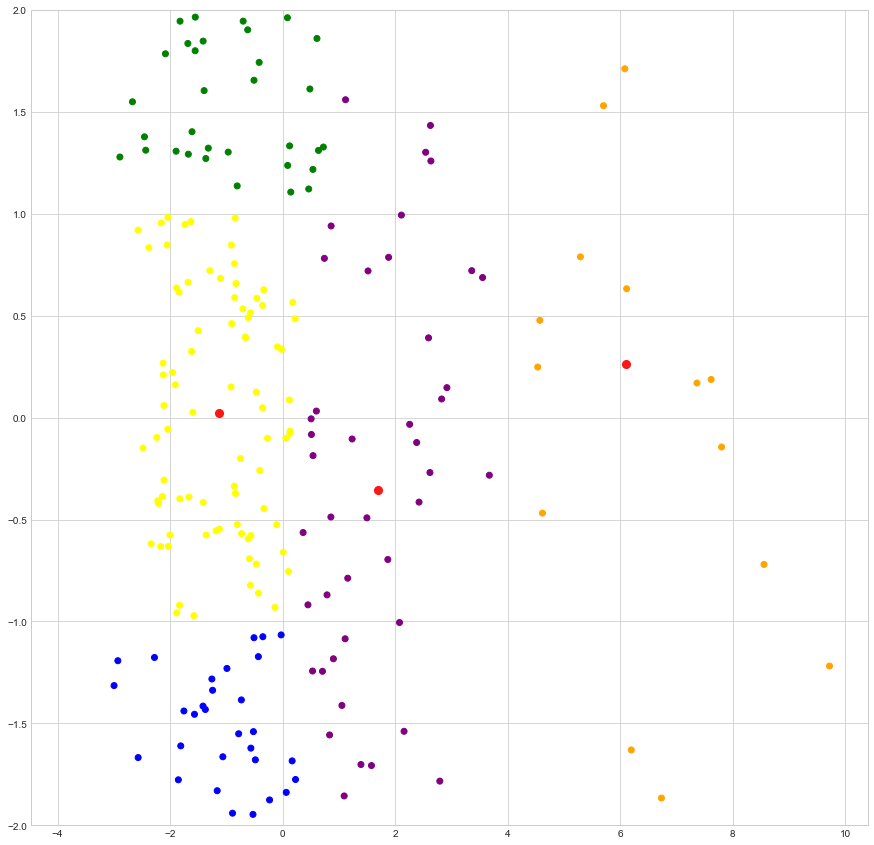

In [165]:
# Plot new clusters
fig, ax = plt.subplots(figsize=(15,15))
labels = ['yellow', 'orange', 'green', 'blue', 'purple']
colored = [labels[k] for k in cluster_preds]

# fig = px.scatter(to_cluster, 2, 1, hover_data = [to_cluster.index], labels = {'0': 'x-values', '1': 'y-values'}, color = colored)
ax.scatter(to_cluster[comps[0]], to_cluster[comps[1]], color = colored)


for ci, c in enumerate(centers):
    ax.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

    
#ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
# plt.legend()
plt.show();

In [166]:
# Plot new clusters
labels = ['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']
colored = [labels[k] for k in cluster_preds]

fig = px.scatter(to_cluster, x = comps[0], y = comps[1], hover_data = [to_cluster.index], color = colored)
fig.update_layout(title_text = 'Plot of Clustered Players', title_x = 0.5, xaxis_title = 'x-values', yaxis_title = 'y-values')

fig.show();